# Taxi predction

## 1. Business Understanding

### Este modelo tem como objetivo prever o tempo total de uma corrida de taxi na cidade de Nova York. Para isto, foi utilizada uma base de dados disponibilizada pela NYC Taxi and Limousine Commission. A base foi disponibilizada pelo site Kaggle.

Link para a pagina do Kaggle: https://www.kaggle.com/c/nyc-taxi-trip-duration

<p> 
    Neste projeto utilizei a metodologia CRISPDM para estrutuar a analise
</p>

### Desenvolvido por Bruno Gabriel de Sousa

## 2. Data Understanding

In [182]:
# Data manipuation
import pandas as pd
import numpy as np
from haversine import haversine
from datetime import datetime, time

# Visualizing
import matplotlib.pyplot as plt

# Model selection and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#Implemetation
from OSMPythonTools.nominatim import Nominatim

In [183]:
#Importando a base de dados para o pandas a partir de um arquivo CSV
df_train = pd.read_csv('train.csv')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Variáveis envolvidas no projeto

#### ID - Registro único de cada corrida na base de dados
#### Vendor ID - ID da empresa associada que fez o registro da corrida
#### Pickup Datetime - Data e horário do início da corrida
#### Dropoff Datetime - Data e horário do final da corrida
#### Passenger Count - Número de passageiros em cada corrida
#### Pickup Longitude - Coordenada de longitude do inicio da corrida
#### Pickup Latitude - Coordenada de latitude do inicio da corrida
#### Dropoff Longitude - Coordenada de longitude do final da corrida
#### Dropoff Latitude - Coordenada de latitude do final da corrida
#### Store and fwd flag - Indicativo se o taxi estava conectado a internet e enviou as informações da corrida antes de continuar a próxima
#### Trip duration - Duração da corrida

In [184]:
#Tipos das variáveis e tamanho da base de dados
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [185]:
#Distruibuilão dos valores em cada coluna da base
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [186]:
#Não há valores nulos ou faltantes em todas as colunas
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [187]:
#Quantidade de valores diferentes em cada variável independente
print("id - {}".format(df_train['id'].nunique()))
print("vendor_id - {}".format(df_train['vendor_id'].nunique()))
print("pickup_datetime - {}".format(df_train['pickup_datetime'].nunique()))
print("dropoff_datetime - {}".format(df_train['dropoff_datetime'].nunique()))
print("passenger_count - {}".format(df_train['passenger_count'].nunique()))
print("pickup_longitude - {}".format(df_train['pickup_longitude'].nunique()))
print("pickup_latitude - {}".format(df_train['pickup_latitude'].nunique()))
print("dropoff_longitude - {}".format(df_train['dropoff_longitude'].nunique()))
print("dropoff_latitude - {}".format(df_train['dropoff_latitude'].nunique()))
print("store_and_fwd_flag - {}".format(df_train['store_and_fwd_flag'].nunique()))

id - 1458644
vendor_id - 2
pickup_datetime - 1380222
dropoff_datetime - 1380377
passenger_count - 10
pickup_longitude - 23047
pickup_latitude - 45245
dropoff_longitude - 33821
dropoff_latitude - 62519
store_and_fwd_flag - 2


<AxesSubplot:>

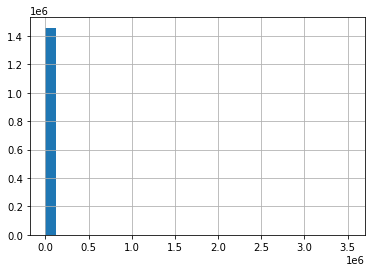

In [188]:
#historiograma da variável dependente
df_train['trip_duration'].hist(bins=30)

{'whiskers': [<matplotlib.lines.Line2D at 0x209607e0f10>,
 'caps': [<matplotlib.lines.Line2D at 0x209607f0610>,
 'boxes': [<matplotlib.lines.Line2D at 0x209607e0bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x209607f0ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x209607f0fd0>],
 'means': []}

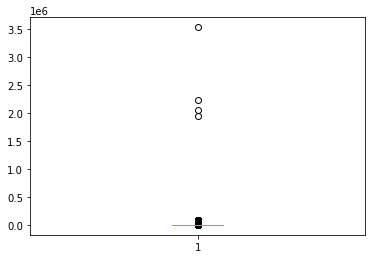

In [189]:
#Gráfico de boxplot da variável dependente
plt.boxplot(df_train['trip_duration'])

In [190]:
#correlação entre as variáveis dependente e independentes
df_train.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000


## Data Preparation

##### A variável store_and_fwd_flag possui apenas dois valores distintos no total. 

In [191]:
df_train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

#### Olhando um pouco mais de perto, a variável store_and_fwd_flag, além de ter poucos valores diferentes também possui uma distribuição muito baixa entre os dados. Como essa variável já é categórica, decidi não utiliza-la para treinar o modelo

In [192]:
#A coluna abaixo não será utilizada
df_train.drop(['store_and_fwd_flag'], axis=1, inplace=True)

In [193]:
df_train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [194]:
df_train.drop(['vendor_id'], axis=1, inplace=True)

#### A variável vendor_id também possui apenas dois valores distintos, mas sua distruibuição é bem mais equilibrada entre os dados. Entretanto, a correlação com a variável independente é baixa. Não há alguma informação explicita na documentação da base de dados que represente cada um dos valores da variável além da breve descrição apresetanda anteriormente. Decidi remove-la da análise

#####    É necessário realizar algumas manipulações na variável pickup datetime. A variável é do tipo string, e como temos  um milhão quatrocentos e oitenta e seis seicentos e quarenta e quatro linhas no dataframe, uma mudança para variável tipo dummy é impraticavel pela quantidade de dados. Vou dividir os dados nas seguintes categorias:

###### 00:00 até 05:59 - madrugada
###### 06:00 até 11:59 - manhã
###### 12:00 até 17:59 - tarde
###### 18:00 até 23:59 - noite

#####    Em relação a variável dropoff datetime, decidi não utilizala pois ela tem o mesmo sentido que o resultado da previsão do tempo da corrida.

In [195]:
#A coluna abaixo não será utilizada
df_train.drop(['dropoff_datetime'], axis=1, inplace=True)

In [196]:
#convertendo variáveis de string para datetime
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

df_temp = df_train.loc[:, ['pickup_datetime']]

#Convertendo horários e datas para períodos do dia na variável pickup_datetime
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(0, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(6, 0, 0)), 'pickup_datetime'] = 'madrugada'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(6, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(12, 0, 0)), 'pickup_datetime'] = 'manha'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(12, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(18, 0, 0)), 'pickup_datetime'] = 'tarde'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(18, 0, 0)) & (df_temp['pickup_datetime'].dt.time <= time(23, 59, 59)), 'pickup_datetime'] = 'noite'

In [197]:
#transformando os dados da coluna pickup_datetime para variáveis dummy
df_train = pd.get_dummies(df_train, columns=['pickup_datetime'])

##### Temos no dataset quatro variáveis de coordenadas geográficas. Com base nessas variáveis conseguimos obter uma distância aproximada da corrida. Isso é interessante para tentar criar uma correlação maior com a variável target trip_duration. Como este é um projeto expiremental, vou utilizar a distância de haversine. Essa distância seria uma linha reta entre dois pontos no globo terrestre. Não utilizei bibliotecas como as do google maps devido a cobrança por requests ou por baixo desempenho de bibliotecas gratuitas.

In [198]:
#Convertendo as coordenadas geográficas para distância em kilometros
kilometragem = df_train.apply(
                                    lambda row: round(haversine((row['pickup_latitude'], row['pickup_longitude']),
                                                        (row['dropoff_latitude'],row['dropoff_longitude'])), 1),
                                    axis=1
                                )

df_train['kilometragem'] = kilometragem

In [199]:
#As colunas abaixo foram transformadas para a nova coluna Kilometragem. Não será mais necessário utiliza-las.
df_train.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)

In [200]:
#como ficou a distribuição dos dados após a transformação das variáveis de coordenada
df_train['kilometragem'].describe()

count    1.458644e+06
mean     3.440831e+00
std      4.296641e+00
min      0.000000e+00
25%      1.200000e+00
50%      2.100000e+00
75%      3.900000e+00
max      1.240900e+03
Name: kilometragem, dtype: float64

In [201]:
df_train[df_train['kilometragem'] == 0]

,id,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
246,id3487442,1,227,0,0,1,0,0.0
291,id0924324,2,1109,0,0,1,0,0.0
323,id2954399,1,40,0,1,0,0,0.0
337,id0790613,1,1778,0,0,0,1,0.0
407,id1145809,6,947,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...
1457746,id1044471,1,12,0,0,1,0,0.0
1458044,id3200588,1,7,1,0,0,0,0.0
1458291,id0078326,1,318,1,0,0,0,0.0
1458544,id3958653,1,38,0,0,0,1,0.0


#### Após a transformação para a variável kilometragem, alguns valores ficaram zerados. Não é interessante para este algoritmo aprender valores zerados de distância. Abaixo será realizado a limpeza destes dados

In [202]:
filtered_km = df_train.query('kilometragem == 0')
df_train.drop(filtered_km.index, inplace=True)

In [203]:
#Como ficou o dataframe após as transformações
df_train.head()

,id,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
0,id2875421,1,455,0,0,0,1,1.5
1,id2377394,1,663,1,0,0,0,1.8
2,id3858529,1,2124,0,1,0,0,6.4
3,id3504673,1,429,0,0,1,0,1.5
4,id2181028,1,435,0,0,0,1,1.2


In [204]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
passenger_count,1.000000,0.008408,0.007668,-0.019891,0.008741,0.004255,0.009857
trip_duration,0.008408,1.000000,-0.003691,-0.005448,-0.003858,0.011759,0.094625
pickup_datetime_madrugada,0.007668,-0.003691,1.000000,-0.207748,-0.263188,-0.235765,0.063879
pickup_datetime_manha,-0.019891,-0.005448,-0.207748,1.000000,-0.411428,-0.368560,-0.036549
pickup_datetime_noite,0.008741,-0.003858,-0.263188,-0.411428,1.000000,-0.466914,0.006950
pickup_datetime_tarde,0.004255,0.011759,-0.235765,-0.368560,-0.466914,1.000000,-0.017831
kilometragem,0.009857,0.094625,0.063879,-0.036549,0.006950,-0.017831,1.000000


#### Com as transformações que realizamos ainda não conseguimos atingir uma correlação interessante entre as variáveis. Entretanto, existem diversos outliers na variável trip_duration (variavel independente). Isso pode estar atrapalhando a correlação entre as variáveis. Abaixo será realizada a limpeza dos dados outliers desta variável utilizando o método IQR (Inter Quartile Range)

In [205]:
Q1 = df_train['trip_duration'].quantile(0.25)
Q3 = df_train['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

filtered = df_train.query('(@Q1 - 1.5 * @IQR) < trip_duration > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2091b5403a0>,
 'caps': [<matplotlib.lines.Line2D at 0x2091b9f4520>,
 'boxes': [<matplotlib.lines.Line2D at 0x2094a865790>],
 'medians': [<matplotlib.lines.Line2D at 0x2091b3d1190>],
 'fliers': [<matplotlib.lines.Line2D at 0x2091b3e9220>],
 'means': []}

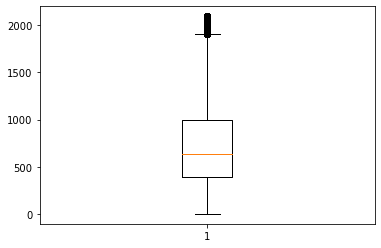

In [206]:
plt.boxplot(df_train['trip_duration'])

<AxesSubplot:>

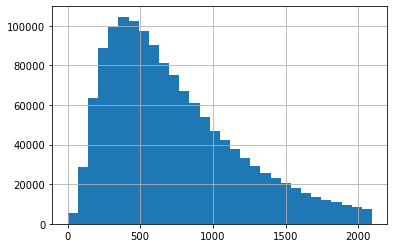

In [207]:
df_train['trip_duration'].hist(bins=30)

#### A distribuição dos valroes e a distância entre os outliers e o máximo do gráfico de boxplot melhorou considerávelmente após a limpeza dos dados na variável trip_duration

In [208]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
passenger_count,1.000000,0.010363,0.008290,-0.020174,0.009423,0.003314,0.004923
trip_duration,0.010363,1.000000,-0.025750,-0.018342,-0.002006,0.038156,0.601224
pickup_datetime_madrugada,0.008290,-0.025750,1.000000,-0.211666,-0.270378,-0.234762,0.122473
pickup_datetime_manha,-0.020174,-0.018342,-0.211666,1.000000,-0.416308,-0.361468,-0.038761
pickup_datetime_noite,0.009423,-0.002006,-0.270378,-0.416308,1.000000,-0.461732,0.033516
pickup_datetime_tarde,0.003314,0.038156,-0.234762,-0.361468,-0.461732,1.000000,-0.086705
kilometragem,0.004923,0.601224,0.122473,-0.038761,0.033516,-0.086705,1.000000


#### Com a retirada dos outliers, podemos ver que a correlação de algumas variáveis responderam muito melhor com a limpeza dos dados. A variável kilometragem foi a que respondeu melhor. 

{'whiskers': [<matplotlib.lines.Line2D at 0x20937396760>,
 'caps': [<matplotlib.lines.Line2D at 0x20937396e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x20937396400>],
 'medians': [<matplotlib.lines.Line2D at 0x209373a1520>],
 'fliers': [<matplotlib.lines.Line2D at 0x209373a1880>],
 'means': []}

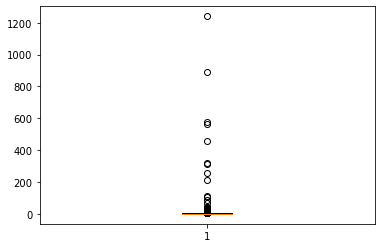

In [209]:
plt.boxplot(df_train['kilometragem'])

<AxesSubplot:>

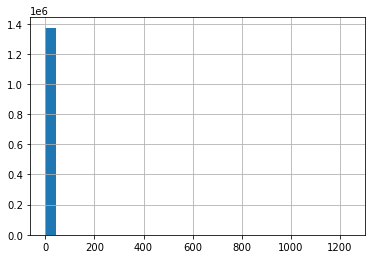

In [210]:
df_train['kilometragem'].hist(bins=30)

##### A variável kilometragem também tem vários outliers. Abaixo será utilizada a mesma técnica utlizada na variável trip_duration para limpar os dados.

In [211]:
Q1 = df_train['kilometragem'].quantile(0.25)
Q3 = df_train['kilometragem'].quantile(0.75)
IQR = Q3 - Q1

filtered_km = df_train.query('(@Q1 - 1.5 * @IQR) < kilometragem > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered_km.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x209374ad5e0>,
 'caps': [<matplotlib.lines.Line2D at 0x209374adca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x209374ad280>],
 'medians': [<matplotlib.lines.Line2D at 0x2094a8793a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2094a879700>],
 'means': []}

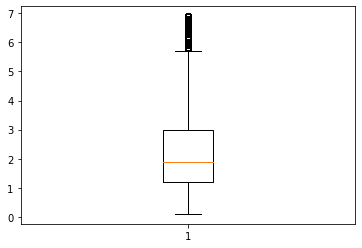

In [212]:
plt.boxplot(df_train['kilometragem'])

<AxesSubplot:>

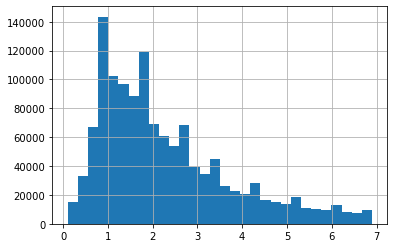

In [213]:
df_train['kilometragem'].hist(bins=30)

In [214]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
passenger_count,1.000000,0.009909,0.008597,-0.021053,0.010043,0.003604,0.004316
trip_duration,0.009909,1.000000,-0.083062,-0.005324,-0.012685,0.075243,0.682482
pickup_datetime_madrugada,0.008597,-0.083062,1.000000,-0.202642,-0.255325,-0.227570,0.095078
pickup_datetime_manha,-0.021053,-0.005324,-0.202642,1.000000,-0.418630,-0.373124,-0.045445
pickup_datetime_noite,0.010043,-0.012685,-0.255325,-0.418630,1.000000,-0.470128,0.054297
pickup_datetime_tarde,0.003604,0.075243,-0.227570,-0.373124,-0.470128,1.000000,-0.078706
kilometragem,0.004316,0.682482,0.095078,-0.045445,0.054297,-0.078706,1.000000


#### A correlação entre as variáveis trip_duration e kilometragem aumentaram 68% com a limpeza dos dados. 

#### Abaixo temos alguns dados da variável passenger_count

<AxesSubplot:>

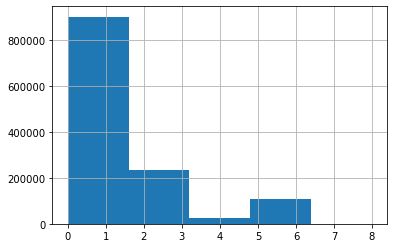

In [215]:
df_train['passenger_count'].hist(bins=5)

{'whiskers': [<matplotlib.lines.Line2D at 0x2094ac9c400>,
 'caps': [<matplotlib.lines.Line2D at 0x2094ac9cac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2094ac9c0a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2094aca71c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2094aca7520>],
 'means': []}

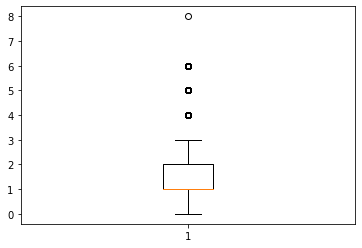

In [217]:
plt.boxplot(df_train['passenger_count'])

#### Esta variável também possui vários outliers. Abaixo será aplicado a limpeza dos dados

In [218]:
Q1 = df_train['passenger_count'].quantile(0.25)
Q3 = df_train['passenger_count'].quantile(0.75)
IQR = Q3 - Q1

filtered_passenger_count = df_train.query('(@Q1 - 1.5 * @IQR) < passenger_count > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered_passenger_count.index, inplace=True)
#df_train['passenger_count'] = df_train['passenger_count'].apply(lambda x: 4 if x > 3 else x)

<AxesSubplot:>

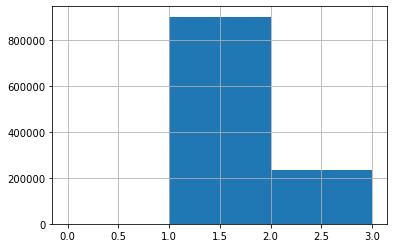

In [219]:
df_train['passenger_count'].hist(bins=3)

{'whiskers': [<matplotlib.lines.Line2D at 0x2094ad57dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x2094ad684c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2094ad57a60>],
 'medians': [<matplotlib.lines.Line2D at 0x2094ad68b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x2094ad68e80>],
 'means': []}

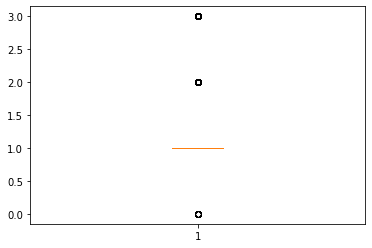

In [220]:
plt.boxplot(df_train['passenger_count'])

In [221]:
#removendo valores onde o número de passageiros é 0
filtered_passenger_count = df_train.query('passenger_count == 0')
df_train.drop(filtered_passenger_count.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2094b0a7b50>,
 'caps': [<matplotlib.lines.Line2D at 0x2094b0b5250>,
 'boxes': [<matplotlib.lines.Line2D at 0x2094b0a77f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2094b0b58e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2094b0b5c10>],
 'means': []}

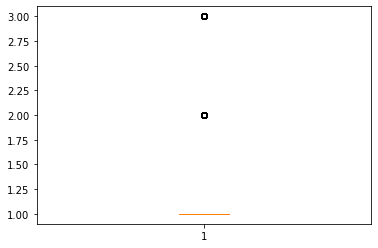

In [222]:
plt.boxplot(df_train['passenger_count'])

In [223]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,kilometragem
passenger_count,1.000000,0.021838,0.017938,-0.055688,0.033456,0.005712,0.013074
trip_duration,0.021838,1.000000,-0.083072,-0.005461,-0.012274,0.074883,0.682727
pickup_datetime_madrugada,0.017938,-0.083072,1.000000,-0.202617,-0.254776,-0.227039,0.095611
pickup_datetime_manha,-0.055688,-0.005461,-0.202617,1.000000,-0.419271,-0.373625,-0.045638
pickup_datetime_noite,0.033456,-0.012274,-0.254776,-0.419271,1.000000,-0.469806,0.054897
pickup_datetime_tarde,0.005712,0.074883,-0.227039,-0.373625,-0.469806,1.000000,-0.079387
kilometragem,0.013074,0.682727,0.095611,-0.045638,0.054897,-0.079387,1.000000


#### A variável passenger_count não possuia uma correlação boa com a variável independente. Mesmo retirando os outliers como feito em outras variáveis, não ajudou muito a aumentar a correlação entre as elas.

## 4 Modeling

#### Com base na alta correlação, será utilizado apenas a variável kilometragem para realizar a previsão. Escolhi o método de regressão linear para treinar o modelo pois as variáveis de distância e tempo tem uma lineariedade propicia para esse tipo de algoritmo


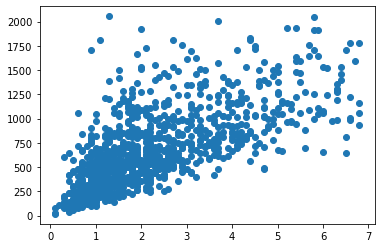

In [224]:
plt.scatter(x=df_train['kilometragem'].tail(1000), y=df_train['trip_duration'].tail(1000))

In [225]:
#valor a ser previsto
y = df_train['trip_duration']

In [226]:
#variável independente
X = df_train.loc[:, ['kilometragem']]

In [227]:
model = LinearRegression()

In [228]:
#divisão da base de dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#treino do modelo
model.fit(X_train, y_train)
#realizando previsões com a variável independente de teste
y_predicted = model.predict(X_test)
#avaliando o modelo
mae(y_predicted, y_test)

218.62209300287967

#### Com os dados que tinhamos para a previsão, alcançamos um valor de erro de 218 segundos entre a linha de regressão e os dados reais. O método de avaliação escolhido para o modelo foi o Mean Absolute Error

## Evaluation

In [166]:
list_x = []
list_y = []
for x in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #treino do modelo
    model.fit(X_train, y_train)
    #realizando previsões com a variável independente de teste
    y_predicted = model.predict(X_test)
    #avaliando o modelo
    list_y.append(mae(y_predicted, y_test))
    list_x.append(x + 1)

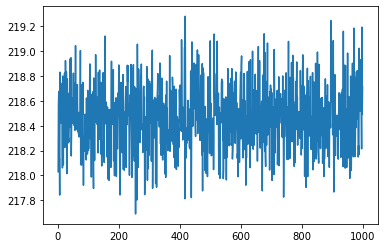

In [167]:
plt.plot(list_x, list_y)

#### Acima foi computada uma amostra de mil treinamentos, teste e validações da base de dados.

## Aplicando o modelo

#### Abaixo desenvolvi uma aplicação simples para aplicar o que foi feito no modelo anteriormente. Você deve entrar com as localizações de origem e destino e o algoritmo dá uma previsão do tempo que a corrida irá levar

In [180]:
nominatim = Nominatim()
input_dados = True
while(input_dados):
  print('---Digite as informações de origem e destino.---')
  print('Os dados devem seguir a seguinte ordem. Rua, número, bairro, cidade, estado, país. \n')

  origin = input("Digite o local de origem: \n")
  print('\n')
  destination = input("Digite o local de destino: \n")

  #pegando coordenadas de origem
  origin_coordiantes = nominatim.query(origin)
  origin_coordiantes = origin_coordiantes.toJSON()

  #pegando coordenadas de destino
  destination_coordiantes = nominatim.query(destination)
  destination_coordiantes = destination_coordiantes.toJSON()

  if len(origin_coordiantes) == 0:
    print("Dados de origem não encontrados, digite novamente \n")
  elif len(destination_coordiantes) == 0:
    print("Dados de destino não encontrados, digite novamente \n")
  else:
    input_dados = False

distance = round(haversine((float(origin_coordiantes[0]['lat']), float(origin_coordiantes[0]['lon'])),
                            (float(destination_coordiantes[0]['lat']),float(destination_coordiantes[0]['lon']))), 1)
previsão = model.predict([[distance]])
print('Tempo esmtimado é de {} minutos'.format(round(previsão[0]/60, 0)))

---Digite as informações de origem e destino.---
Os dados devem seguir a seguinte ordem. Rua, número, bairro, cidade, estado, país. 

Digite o local de origem: 
Timbó, Santa Catarina, Brasil


Digite o local de destino: 
Curitiba, Paraná, Brasil


[nominatim] downloading data: search


Tempo esmtimado é de 481.0 minutos
